# Exploratory Analysis
---

## 1. Imports

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from sklearn.utils import resample

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter

## 2. Load Dataset

In [5]:
email_df = pd.read_feather("./data/2_clean_email_dataset.feather")
email_df

,Email Type,Email Text,Cleaned Email Text
0,spam,viiiiiiagraaaa\nonly for the ones that want to...,viiiiiiagraaaa one want make scream prodigy sc...
1,ham,got ice thought look az original message ice o...,got ice thought look az original message ice o...
2,spam,yo ur wom an ne eds an escapenumber in ch ma n...,yo ur wom ne ed escapenumber ch n b e th n f h...
3,spam,start increasing your odds of success & live s...,start increasing odds success live sexually he...
4,ham,author jra date escapenumber escapenumber esca...,author jra date escapenumber escapenumber esca...
...,...,...,...
221044,phish,The cure for dysfunction and impotency availab...,cure dysfunction impotency available
221045,phish,\n\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\...,cnn alert custom alert alert name custom alert...
221046,phish,\n\nLab-tested female sensual leverage!\n\nPat...,labtested female sensual leverage patient acce...
221047,phish,\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\n ...,cnn alert custom alert alert name custom alert...


## 3. Statistics
Get ham, spam, and phish row count after cleanup.

In [6]:
email_df["Email Type"].value_counts()

Email Type
ham      102159
spam      91691
phish     27196
Name: count, dtype: int64

Most data is legitimate (ham), so the model may overfit to it. Sampling balance is needed

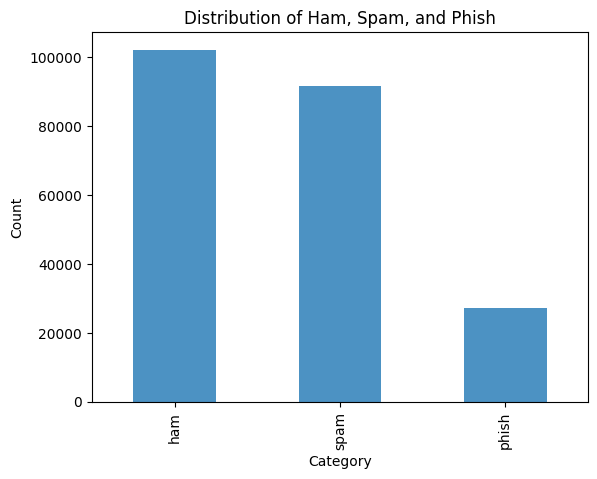

In [7]:
email_df["Email Type"].value_counts().plot(kind='bar', alpha=0.8)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Ham, Spam, and Phish')
plt.show()

We must undersample `ham` and `spam` to 50000, and oversample `phish` up to 50000 using SMOTE.

In [15]:
balanced_df = email_df.copy(deep=True)
balanced_df.drop(columns=["Email Text"], inplace=True)
balanced_df.rename(columns={"Cleaned Email Text": "Email Text"}, inplace=True)

# Get class counts
class_counts = balanced_df['Email Type'].value_counts()

# Define target count for majority class after undersampling
target_count = 30000

# Separate by class
dfs = {}
for cls in balanced_df['Email Type'].unique():
    dfs[cls] = balanced_df[balanced_df['Email Type'] == cls]

# Undersample majority class
majority_class = class_counts.idxmax()
dfs[majority_class] = resample(
    dfs[majority_class],
    replace=False,
    n_samples=target_count,
    random_state=42
)

# Oversample minority classes to reach target_majority_count
for cls, df in dfs.items():
    if cls != majority_class:
        dfs[cls] = resample(
            df,
            replace=True,
            n_samples=target_count,
            random_state=42
        )

# Combine back into a single dataframe
balanced_df = pd.concat(list(dfs.values()))

# Shuffle
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
balanced_df['Email Type'].value_counts()


Email Type
phish    30000
spam     30000
ham      30000
Name: count, dtype: int64

In [13]:
balanced_df

,Email Type,Email Text
0,phish,hello wish accost request would immense benefi...
1,spam,penis enlarge patch penis make much shadow htt...
2,ham,past week receiving information risk managemen...
3,phish,size matter change life today try today nothin...
4,phish,get free bottle today change life wait stud ac...
...,...,...
89995,spam,kick education notch http smartwho info ramove...
89996,ham,subject summary name day dear linguist decembe...
89997,phish,men womens heath beauty product broad range pr...
89998,spam,food difficult happen completely tear news win...


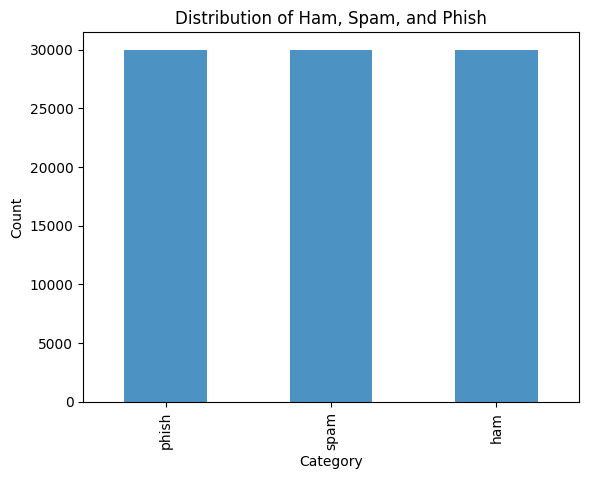

In [16]:
balanced_df["Email Type"].value_counts().plot(kind='bar', alpha=0.8)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Ham, Spam, and Phish')
plt.show()

Export as balanced dataframe to a feather file for later use with the SVM model.

In [17]:
balanced_df.to_feather("./data/2_balanced_email_dataset.feather")

### Text Characteristics of Original Email Data
Get the text characteristics before the data was cleaned via the column `"Email Text"`.

In [18]:
# Clean punctuation except for periods, question marks, and exclamation points to get sentences.
orig_email_df = email_df.copy(deep=True)

# Text length metrics
orig_email_df["char_count"] = orig_email_df["Email Text"].str.len()
orig_email_df["word_count"] = orig_email_df["Email Text"].apply(word_tokenize).apply(len)
orig_email_df["sentence_count"] = orig_email_df["Email Text"].apply(sent_tokenize).apply(len)

# # Count URLs
url_pattern = r"http[s]?://\S+|www\.\S+"
orig_email_df["url_count"] = orig_email_df["Email Text"].apply(
    lambda x: len(re.findall(url_pattern, x))
)

# Count special characters
orig_email_df["special_chars"] = orig_email_df["Email Text"].apply(
    lambda x: sum(not c.isalnum() and not c.isspace() for c in x)
)

In [19]:
orig_email_df[["char_count", "word_count", "sentence_count", "url_count", "special_chars"]].describe()

,char_count,word_count,sentence_count,url_count,special_chars
count,2.210460e+05,2.210460e+05,221046.000000,221046.000000,221046.000000
mean,1.750091e+03,2.670197e+02,4.418356,0.386549,32.124684
std,2.685323e+04,3.482425e+03,22.855648,2.774977,587.257774
min,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,3.160000e+02,5.100000e+01,1.000000,0.000000,0.000000
50%,7.420000e+02,1.200000e+02,1.000000,0.000000,1.000000
75%,1.781000e+03,2.810000e+02,1.000000,0.000000,10.000000
max,1.151031e+07,1.585483e+06,3093.000000,120.000000,215985.000000


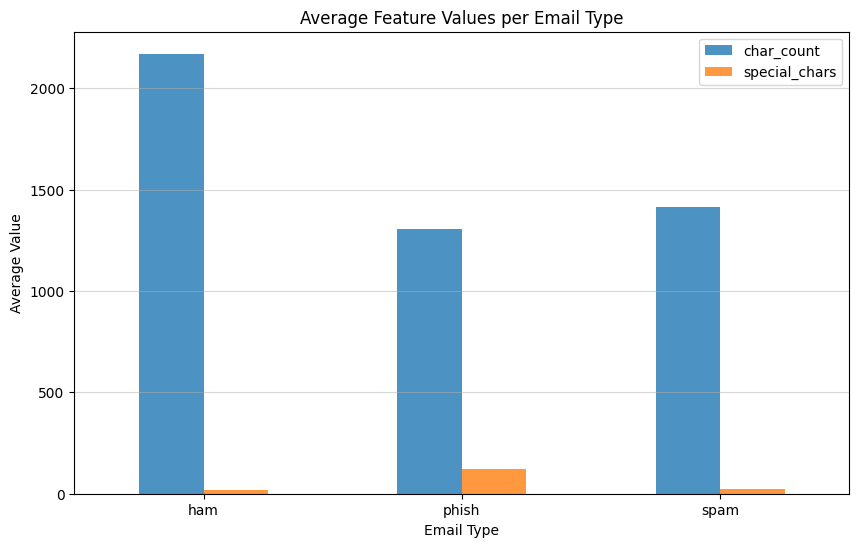

In [20]:
feature_cols = ["char_count", "special_chars"]
grouped = orig_email_df.groupby("Email Type")[feature_cols].mean()

grouped.plot(kind="bar", figsize=(10,6), alpha=0.8)
plt.title("Average Feature Values per Email Type")
plt.xlabel("Email Type")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.5)
plt.show()

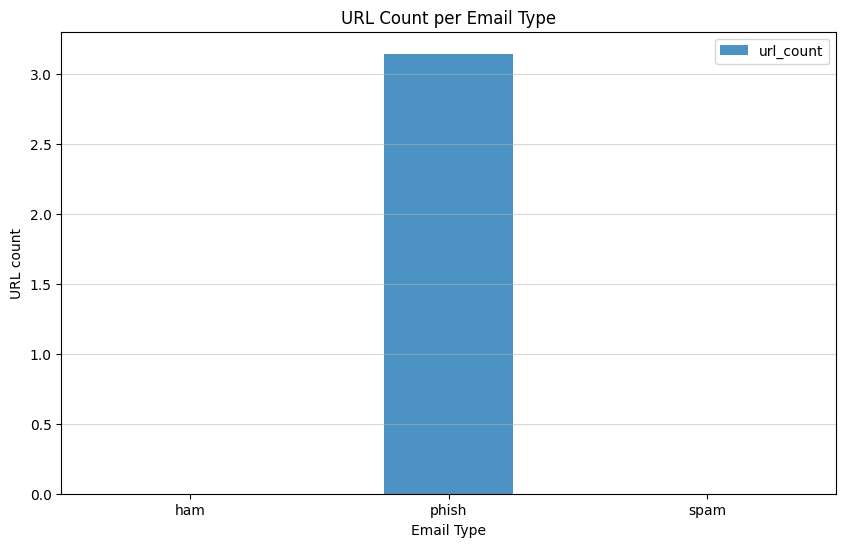

In [21]:
feature_cols = ["url_count"]
grouped = orig_email_df.groupby("Email Type")[feature_cols].mean()

grouped.plot(kind="bar", figsize=(10,6), alpha=0.8)
plt.title("URL Count per Email Type")
plt.xlabel("Email Type")
plt.ylabel("URL count")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.5)
plt.show()

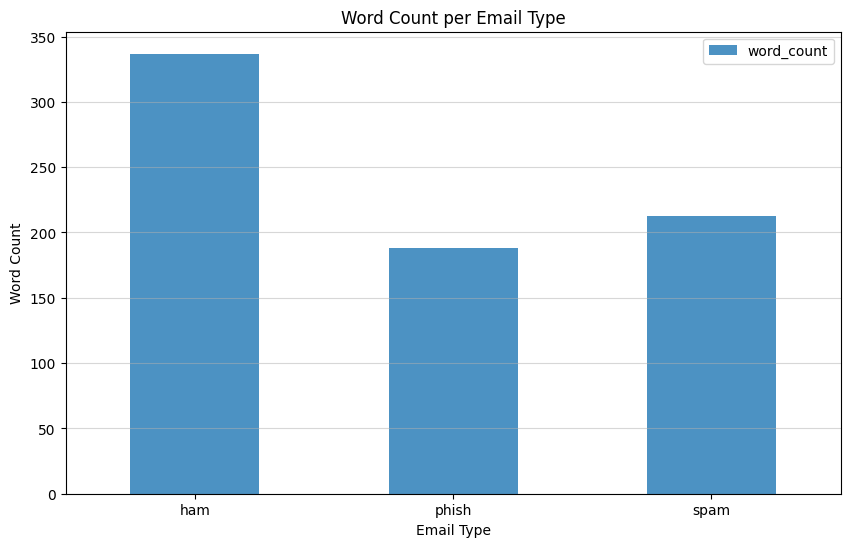

In [22]:
feature_cols = ["word_count"]
grouped = orig_email_df.groupby("Email Type")[feature_cols].mean()

grouped.plot(kind="bar", figsize=(10,6), alpha=0.8)
plt.title("Word Count per Email Type")
plt.xlabel("Email Type")
plt.ylabel("Word Count")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.5)
plt.show()

Sentence count between ham, phish, and spam.

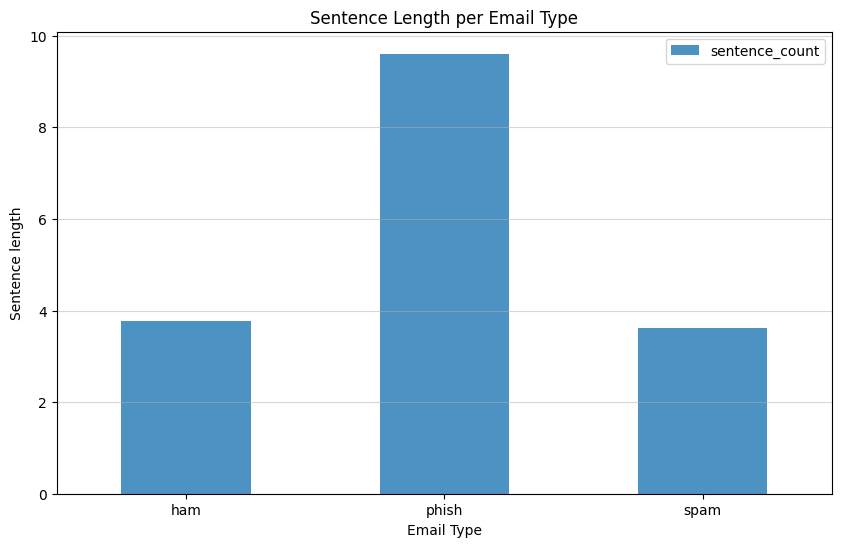

In [23]:
feature_cols = ["sentence_count"]
grouped = orig_email_df.groupby("Email Type")[feature_cols].mean()

grouped.plot(kind="bar", figsize=(10,6), alpha=0.8)
plt.title("Sentence Length per Email Type")
plt.xlabel("Email Type")
plt.ylabel("Sentence length")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.5)
plt.show()

## The Most Common Words for Each Category (After Cleaning)

In [24]:
stop_words = set(stopwords.words("english"))

def get_top_words_clean(texts, n=20):
    """Return top n most common words."""
    all_words = []
    for txt in texts:
        all_words.extend(txt.split()) 
    return Counter(all_words).most_common(n)

Initialize `top_words` and populate with top words if not already populated (process takes some time when initialized).

In [25]:
categories = balanced_df["Email Type"].unique().tolist()
top_words_clean = dict()

for category in categories:
    words = get_top_words_clean(balanced_df[balanced_df["Email Type"] == category]["Email Text"])
    top_words_clean[category] = words

pd.DataFrame(top_words_clean).head()

,phish,spam,ham
0,"(email, 17677)","(escapenumber, 368292)","(escapenumber, 639122)"
1,"(top, 16787)","(escapelong, 87979)","(escapelong, 81867)"
2,"(account, 15696)","(com, 33002)","(enron, 48928)"
3,"(news, 13920)","(bescapenumber, 32336)","(com, 44693)"
4,"(money, 12726)","(cescapenumber, 32178)","(http, 29728)"


### Remove Words that are Overrepresented
Some words do not appear to provide any additional value, like `enron` which is where the ham & spam emails are from. Let's remove them.

In [30]:
def remove_words(text, words_to_remove: list[str]):
    """Uses re.sub() to replace all occurrences of words to remove."""
    regex_pattern = r'\b(?:' + '|'.join(words_to_remove) + r')\b'
    return re.sub(regex_pattern, '', str(text), flags=re.IGNORECASE)

balanced_df["Email Text"] = balanced_df["Email Text"].apply(
    lambda x: remove_words(
        x,
        ["enron", "escapenumber", "escapelong",
         "bescapenumber", "cescapenumber", "aescapenumber" "eescapenumber",
         "com", "http", "www", "b", "e"]
    )
)

for category in categories:
        words = get_top_words_clean(balanced_df[balanced_df["Email Type"] == category]["Email Text"])
        top_words_clean[category] = words

pd.DataFrame(top_words_clean).head(10)

,phish,spam,ham
0,"(email, 17677)","(company, 19704)","(message, 25452)"
1,"(top, 16787)","(one, 15426)","(subject, 23545)"
2,"(account, 15696)","(price, 15151)","(please, 22675)"
3,"(news, 13920)","(email, 12903)","(company, 22286)"
4,"(money, 12726)","(eescapenumber, 12172)","(would, 21796)"
5,"(cnncom, 12454)","(may, 12002)","(new, 21321)"
6,"(please, 10812)","(j, 11639)","(r, 20073)"
7,"(name, 10535)","(k, 11274)","(sent, 19736)"
8,"(one, 10370)","(please, 11177)","(said, 18458)"
9,"(bank, 9701)","(time, 11094)","(time, 18147)"


Save updated data.

In [31]:
balanced_df.to_feather("./data/2_balanced_email_dataset.feather")

### Show Most Common Words Plots and Wordclouds

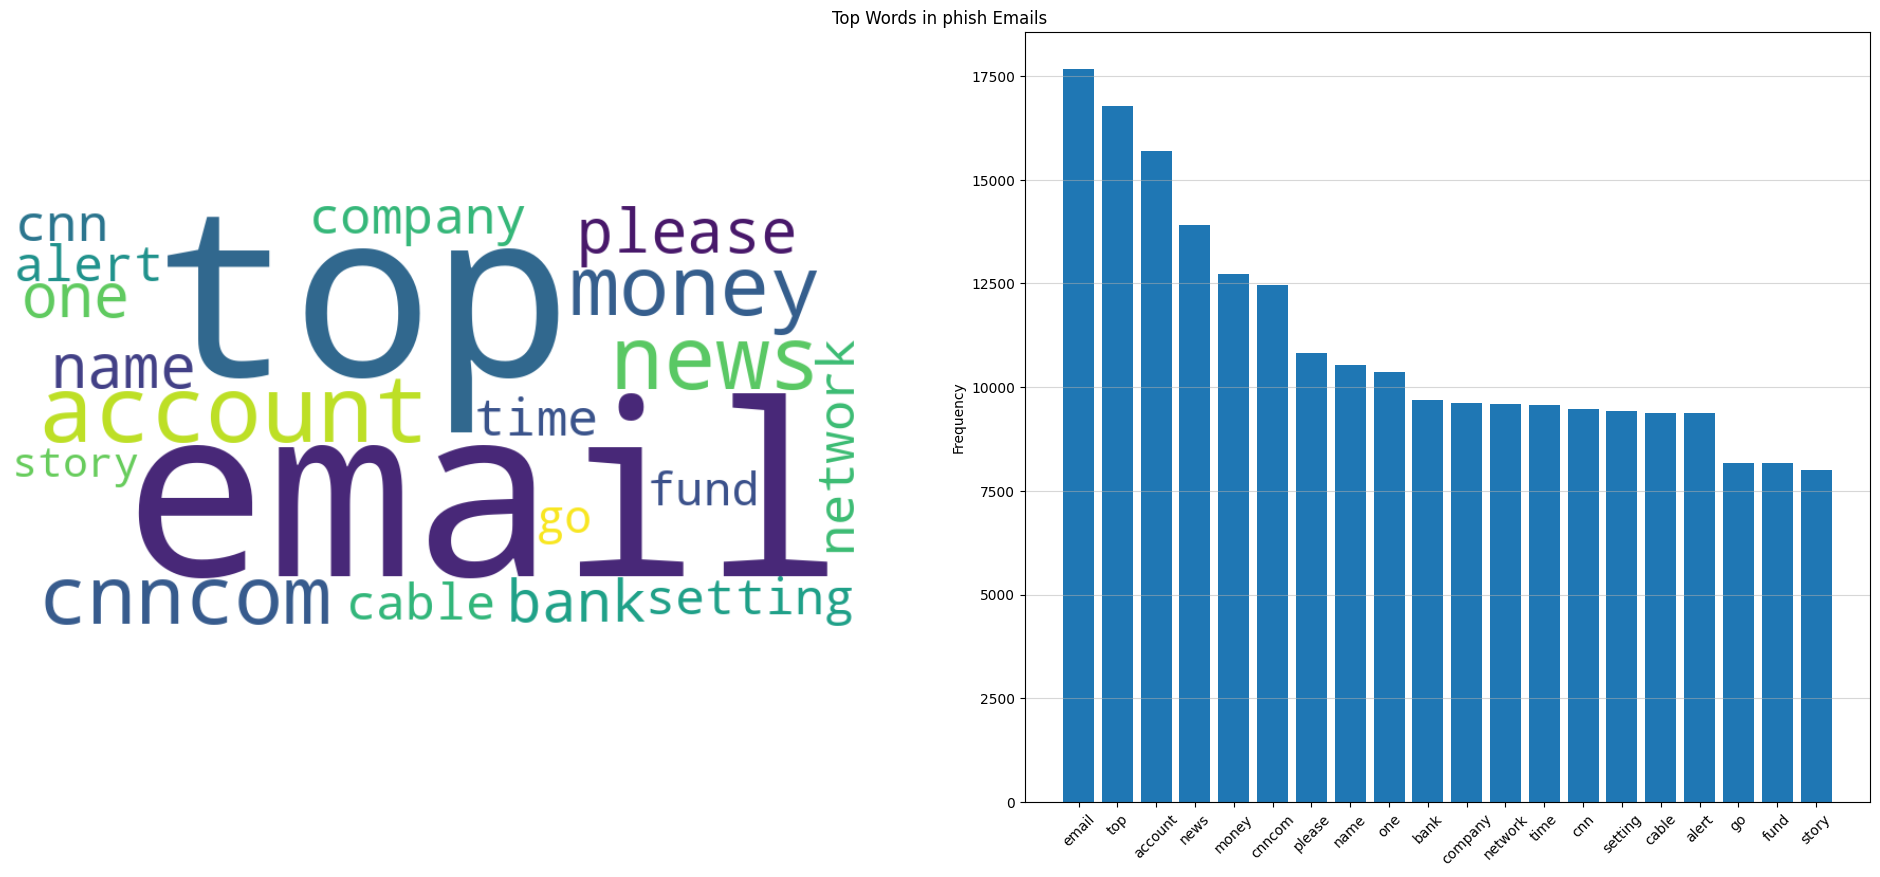

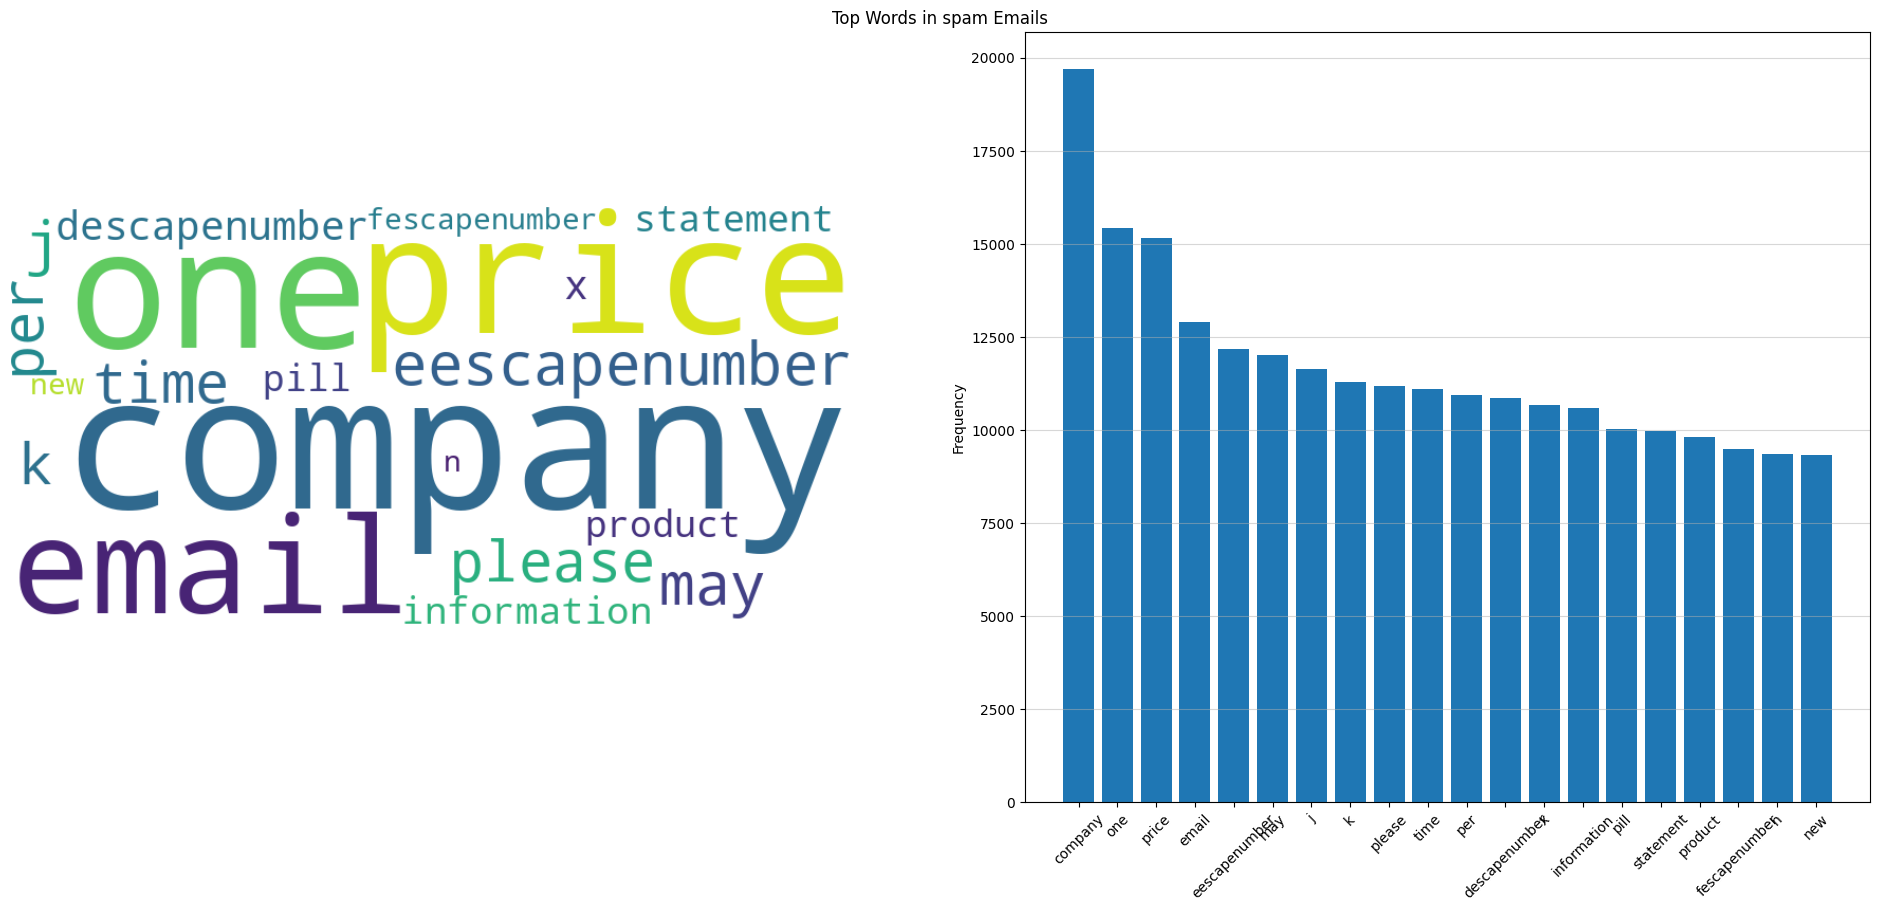

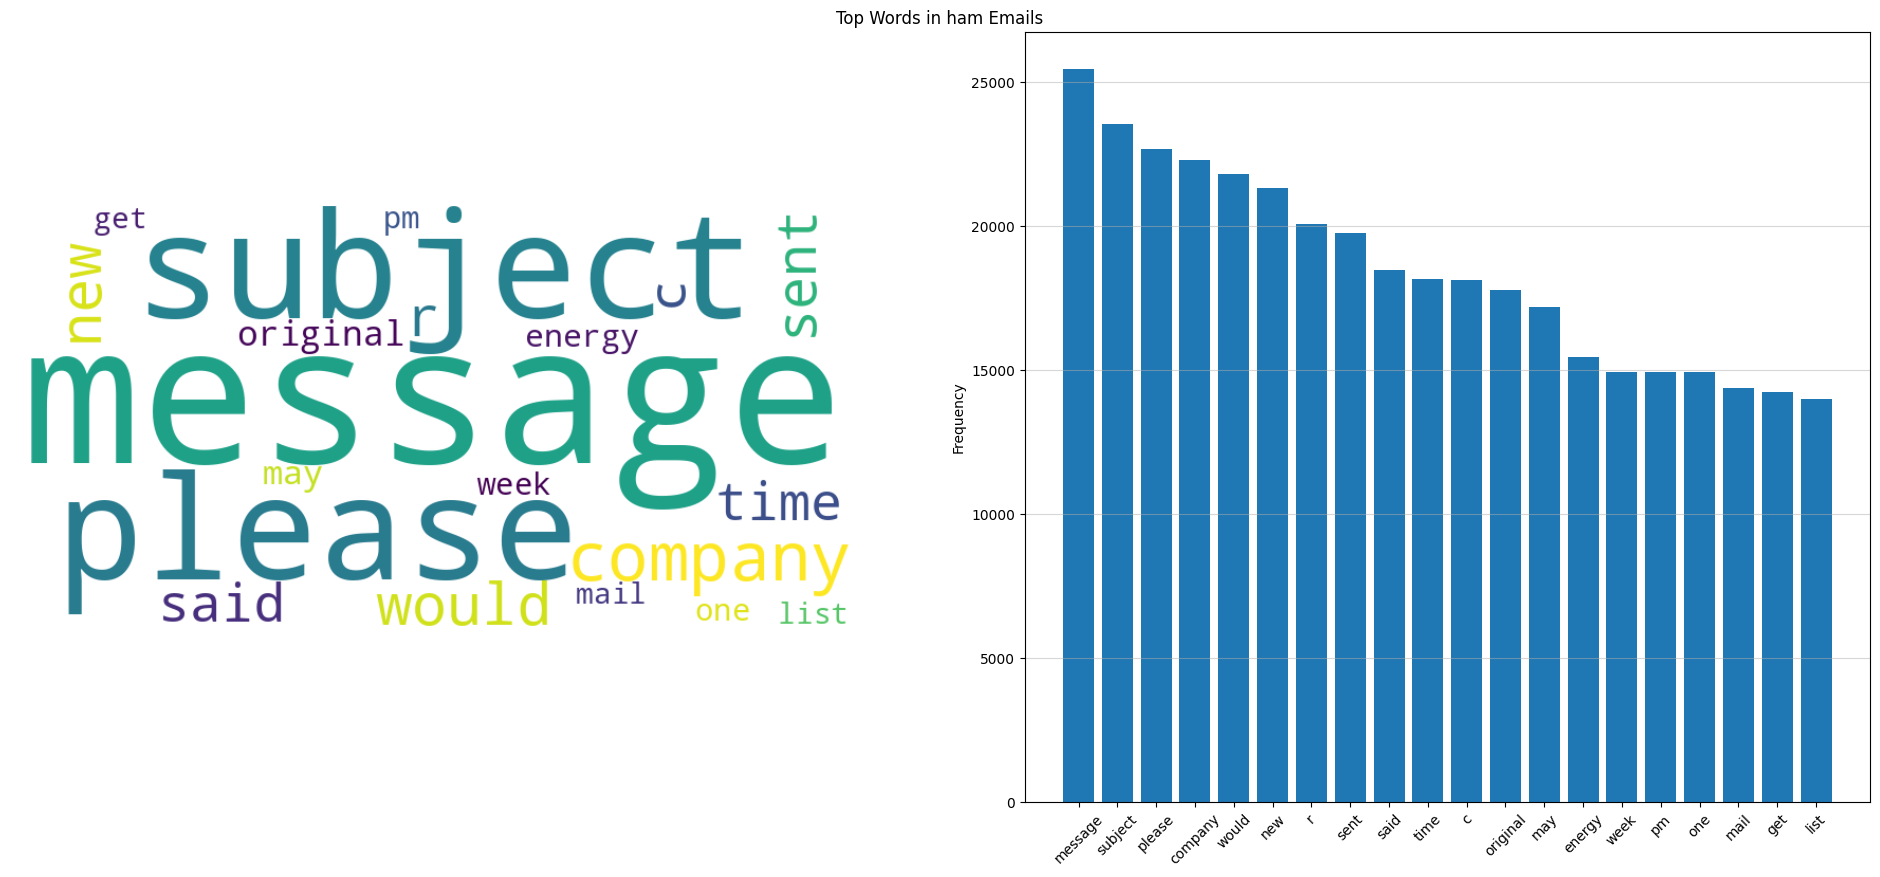

In [33]:
for category in categories:
    words, counts = zip(*top_words_clean[category])

    plt.figure(figsize=(24, 10), alpha=0.8)
    plt.title(f"Top Words in {category} Emails")
    plt.axis('off')

    wordcloud = WordCloud(
        width=800, height=400, background_color='white'
    ).generate_from_frequencies(dict(top_words_clean[category]))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.5)
    plt.show()